# Customer Age Assessment

## A grocery store deploys computer vision system for customer photo analysis. So our goal is to learn a model that assess an age of buyers. It'll help company to control alcohol sellings and recommend to customers other items depends on their age group

## Data Preprocessing

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers.experimental import preprocessing

path = '/content/gdrive/MyDrive/Colab Notebooks/Faces/appa-real-release/'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#see what's gpu we got
!nvidia-smi

Thu Feb 10 07:42:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# load data
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Faces/allcategories_train.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file       4113 non-null   object
 1   gender     4113 non-null   object
 2   race       4113 non-null   object
 3   makeup     4113 non-null   object
 4   time       4113 non-null   object
 5   happiness  4113 non-null   object
dtypes: object(6)
memory usage: 192.9+ KB


In [ ]:
data.head()

,file,gender,race,makeup,time,happiness
0,000000.jpg,male,caucasian,nomakeup,modernphoto,neutral
1,000001.jpg,female,caucasian,verysubtle,modernphoto,neutral
2,000002.jpg,female,caucasian,notclear,modernphoto,slightlyhappy
3,000003.jpg,female,caucasian,verysubtle,modernphoto,happy
4,000004.jpg,female,caucasian,makeup,modernphoto,slightlyhappy


In [ ]:
gt_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Faces/appa-real-release/gt_train.csv')

In [ ]:
gt_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133935 entries, 0 to 133934
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   file_name      133935 non-null  object
 1   real_age       133935 non-null  int64 
 2   apparent_age   133935 non-null  int64 
 3   worker_age     133935 non-null  int64 
 4   worker_gender  25374 non-null   object
dtypes: int64(3), object(2)
memory usage: 5.1+ MB


In [ ]:
gt_train.head()

,file_name,real_age,apparent_age,worker_age,worker_gender
0,000000.jpg,4,5,36,male
1,000000.jpg,4,4,38,female
2,000000.jpg,4,7,52,female
3,000000.jpg,4,5,50,male
4,000000.jpg,4,4,52,female


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of persons age')

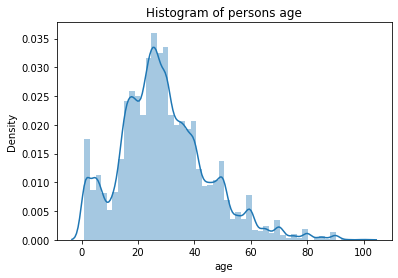

In [ ]:
#age distribution
sns.distplot(a=gt_train['real_age'], axlabel='age')
plt.title('Histogram of persons age')

 An average age lays near 30 years. Distribution is almost normal.

In [ ]:
#load and plot 15 images from the data

labels = pd.read_csv(path + 'gt_train.csv') 
train_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1/255) 
train_datagen_flow = train_datagen.flow_from_dataframe( 
dataframe = labels, 
directory = path + '/train/', 
x_col='file_name', 
y_col='real_age', 
target_size=(224, 224), 
batch_size=16, 
class_mode='raw', 
subset = 'training', 
seed=12345) 

Found 100452 validated image filenames.


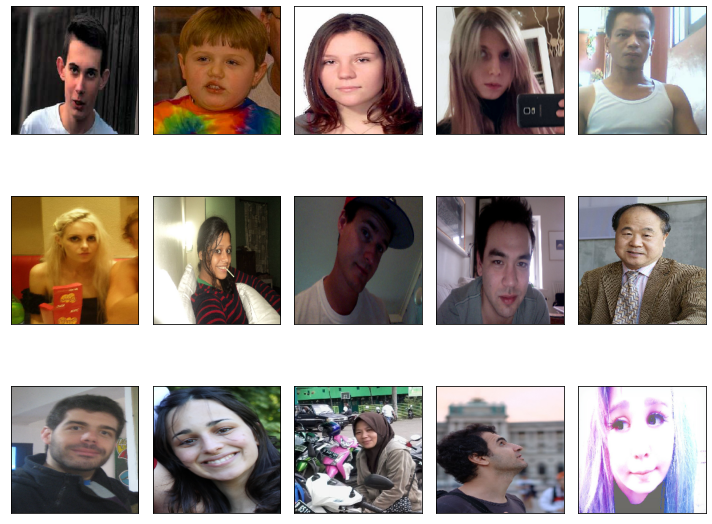

In [ ]:
features, target = next(train_datagen_flow)

fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [ ]:
features.shape

(16, 224, 224, 3)

## Certain functions

In [ ]:
# load train data
def load_train(path): 
    labels = pd.read_csv(path + 'gt_train.csv') 
    train_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1/255) #horizontal_flip=False) 
    train_datagen_flow = train_datagen.flow_from_dataframe( 
    dataframe = labels, 
    directory = path + '/train/', 
    x_col='file_name', 
    y_col='real_age', 
    target_size=(224, 224), 
    batch_size=16, 
    class_mode='raw', 
    subset = 'training', 
    seed=12345) 

    return train_datagen_flow 

In [ ]:
# load test data
def load_test(path): 
    labels = pd.read_csv(path + 'gt_test.csv') 
    test_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1/255) 
    test_datagen_flow = test_datagen.flow_from_dataframe( 
    dataframe = labels, 
    directory = path + '/test/', 
    x_col='file_name', 
    y_col='real_age', 
    target_size=(224, 224), 
    batch_size=16, 
    class_mode='raw', 
    subset = 'validation', 
    seed=12345) 

    return test_datagen_flow

In [ ]:
#create a model
def create_model(input_shape):
    optimizer = Adam(0.00005, momentum)

    data_augmentation = Sequential([
                                    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=12345, name=None),
                                    # tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.5, seed=12345, name=None),
                                    # tf.keras.layers.experimental.preprocessing.RandomWidth(factor=0.3, interpolation='bilinear', seed=12345, name=None),
                                    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.5, width_factor=None, fill_mode='reflect', interpolation='bilinear', seed=None, fill_value=0.0)

    ])

    backbone = InceptionResNetV2(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)

    backbone.trainable = True

    model = Sequential()

    model.add(data_augmentation)

    model.add(backbone)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(units=1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

## Machine Learning

In [ ]:
# load the data
train_data = load_train(path)
test_data = load_test(path)



Found 100452 validated image filenames.
Found 18866 validated image filenames.


In [ ]:
model = create_model((224, 224, 3))

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
model.build((None, 224, 224, 3))

In [ ]:
#model layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 5, 5, 1536)       54336736  
 er)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 54,338,273
Trainable params: 54,277,729
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
#training a model
history = model.fit(train_data, 
            validation_data=test_data, 
            batch_size=None, 
            epochs=3, 
            steps_per_epoch=None, 
            validation_steps=None, 
            verbose=2, 
            shuffle=True)

Epoch 1/3
6279/6279 - 2301s - loss: 6.3800 - mean_absolute_error: 1.8154 - val_loss: 140.2325 - val_mean_absolute_error: 8.5194 - 2301s/epoch - 366ms/step
Epoch 2/3
6279/6279 - 2294s - loss: 3.8916 - mean_absolute_error: 1.3953 - val_loss: 139.8421 - val_mean_absolute_error: 8.6651 - 2294s/epoch - 365ms/step
Epoch 3/3
6279/6279 - 2297s - loss: 2.9880 - mean_absolute_error: 1.1920 - val_loss: 150.3772 - val_mean_absolute_error: 9.0229 - 2297s/epoch - 366ms/step


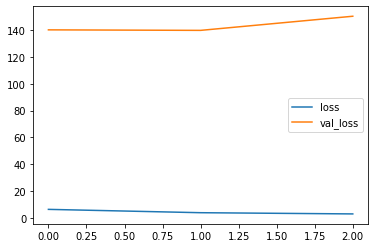

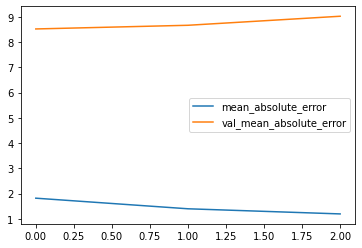

In [ ]:
#plot metric and loss function
model_frame = pd.DataFrame(history.history)
model_frame.loc[:, ['loss', 'val_loss']].plot()
model_frame.loc[:, ['mean_absolute_error', 'val_mean_absolute_error']].plot()

# Conclusion

In this project we've built a model based on the neural network InceptionResNetV2. We run our model on 3 epochs and got mean absolute error 1.4 on train and 8.5 on test. So it might be helpful in solving business task such as building customer recomendation system and alcohol and tobacco sellings control.